#### Gonna try something epic here

My idea is to create a function/script/ability to overlay a sankey diagram over a bus route to represent the ons/offs and current passenger load, all while being displayed on the map. Hopefully would include hover/tooltip capabilities as well. IDK really how I will start but heres to trying

I will try initially to use the E line to do this. I already have the segment data which will be helpful but the main reason I am using the eline data is that it is mostly straight!! This will help as I am developing for a few reasons.

In [1]:
### Gonna start with the imports. Nothing weird don't freak out.
import pandas as pd
import geopandas as gpd
import numpy as np

pd.set_option('display.max_columns', None) ### This line makes all the columns display, rather than ellipses shorten

In [2]:
### import the e line data with segments

kcm_segment_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Routes_for_King_County_Metro___transitroute_line"
kcm_point_data = "C:/Users/aaron/CoreGIS_Work/CoreGIS Work Sync/COREGIS_work/RapidRide E/Data/Source/Transit_Stops_for_King_County_Metro___transitstop_point"

all_kcm_segment_data = gpd.read_file(kcm_segment_data)
all_kcm_point_data = gpd.read_file(kcm_point_data)


In [3]:
### compiling a list of stops that I will use for this experiment. Mostly in a straight line and not too many of them.
e_line_northbound_stop_list = [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850]

e_line_northbound_stops = all_kcm_point_data[all_kcm_point_data['STOP_ID'].isin(e_line_northbound_stop_list)]
e_line_northbound_stops = e_line_northbound_stops[e_line_northbound_stops['CURRENT_NE'] == 'IN SERVICE'] ## eliminating 3X stops


In [4]:
e_line_full_segment = all_kcm_segment_data[all_kcm_segment_data['ROUTE_NUM'] == 675] ##675 is the E line's route number

In [5]:
e_line_northbound_stops.explore()

### Ridership data stuffs

In [6]:
### gonnna fabricate some data about the ons/offs/avg departing load. This isn't about reflecting reality at the current moment
## Stop list, south to north --> [7690, 7710, 7730, 7750, 7770, 7790, 7810, 7850]

##completely made up
## stop_num: [boardings, alightings]

#type = dict
ridership_data = {
    7690: [12, 0],
    7710: [14, 6],
    7730: [13, 2],
    7750: [5, 20],
    7770: [8, 6],
    7790: [10, 14],
    7810: [3, 6],
    7850: [2, 3]
}



In [7]:
### This cell calculates the departing load from every stop!
departing_load = 0

for stop_num in ridership_data.keys():    
    current_boardings = ridership_data[stop_num][0]
    current_alightings = ridership_data[stop_num][1]

    departing_load = departing_load + current_boardings - current_alightings

    ridership_data[stop_num].append(departing_load)
    #print (f"stop_num - {stop_num}, current_boardings - {current_boardings}, current_alightings - {current_alightings}, departing_load - {departing_load}")

### Now its time to try and draw a line between each stop

In [34]:
### make a function enabling the #shortest_line function to work with just two points.

def shortest_line_between(geom1, geom2):
    return gpd.GeoSeries([geom1]).shortest_line(gpd.GeoSeries([geom2]))#.iloc[0]


In [9]:
stop_1 = e_line_northbound_stops.iloc[0] ## type --> series
stop_2 = e_line_northbound_stops.iloc[1] ## type --> series
stop_3 = e_line_northbound_stops.iloc[2] ## type --> series
stop_4 = e_line_northbound_stops.iloc[3] ## type --> series
stop_5 = e_line_northbound_stops.iloc[4] ## type --> series
stop_6 = e_line_northbound_stops.iloc[5] ## type --> series

stop_geometry_dict = {}

### get the point geography variable for every stop
for i in range (0, 6):
    stop_geometry_dict[f"stop_number_{i+1}_geo"] = globals()[f"stop_{i+1}"]['geometry']

#first_stop_geo = first_stop['geometry']
#second_stop_geo = second_stop['geometry']
#third_stop_geo = third_stop['geometry']
#fourth_stop_geo = fourth_stop['geometry']
#fourth_stop_geo = fourth_stop['geometry']
#fourth_stop_geo = fourth_stop['geometry']

In [29]:
#stop_geometry_dict

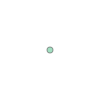

In [11]:
stop_geometry_dict["stop_number_3_geo"]

In [41]:
first_segment = shortest_line_between(stop_geometry_dict["stop_number_1_geo"], stop_geometry_dict["stop_number_2_geo"])
second_segment = shortest_line_between(stop_geometry_dict["stop_number_2_geo"], stop_geometry_dict["stop_number_3_geo"])

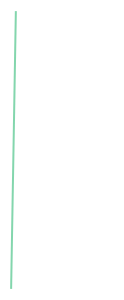

In [42]:
first_segment

In [47]:
segment_gdf = gpd.GeoDataFrame({'Stop_ID': [7690, 7710], 'geometry': [first_segment, second_segment]}, geometry = 'geometry', crs = "EPSG:2926")

In [48]:
segment_gdf.head()

,Stop_ID,geometry
0,7690,"LINESTRING (1268255 253055, 1268277 254342.3)"
1,7710,"LINESTRING (1268277 254342.3, 1268298 255739.1)"


In [16]:
## make the two-stop series for every stop-pair

num_stops = len(stop_geometry_dict)

#first_seg_series = gpd.GeoSeries([first_stop_geo, second_stop_geo], crs = "EPSG:2926")

two_stop_series_dict = {}

for x in range (0, num_stops - 1):
    current = x + 1
    two_stop_series_dict[f"segment_series_number_{x}"] = gpd.GeoSeries([stop_geometry_dict[f'stop_number_{current}_geo'], stop_geometry_dict[f'stop_number_{current + 1}_geo'] ], crs = "EPSG:2926")

In [17]:
two_stop_series_dict

{'segment_series_number_0': 0      POINT (1268255 253055)
 1    POINT (1268277 254342.3)
 dtype: geometry,
 'segment_series_number_1': 0    POINT (1268277 254342.3)
 1    POINT (1268298 255739.1)
 dtype: geometry,
 'segment_series_number_2': 0    POINT (1268298 255739.1)
 1    POINT (1268313 257094.7)
 dtype: geometry,
 'segment_series_number_3': 0    POINT (1268313 257094.7)
 1    POINT (1268312 258317.8)
 dtype: geometry,
 'segment_series_number_4': 0    POINT (1268312 258317.8)
 1    POINT (1268343 259603.1)
 dtype: geometry}

In [ ]:
#shortest_segment = stops_series.shortest_line(second_stop_geo)
#first_segment = first_seg_series.shortest_line(second_stop_geo)
#second_segment = second_seg_series.shortest_line(third_stop_geo)

In [21]:
type(two_stop_series_dict["segment_series_number_0"])

geopandas.geoseries.GeoSeries

In [24]:
segment_1 = two_stop_series_dict["segment_series_number_0"].shortest_line(two_stop_series_dict["segment_series_number_1"])
segment_2 = two_stop_series_dict["segment_series_number_1"].shortest_line(two_stop_series_dict["segment_series_number_2"])

In [27]:
segment_1.explore()

In [28]:
multimap = segment_1.explore(color = 'red')

segment_2.explore(m = multimap, color = 'green')

In [ ]:
type(first_segment)

In [ ]:
#type (shortest_segment)# = GeoSeries
first_segment.explore()
#second_segment.explore()